# 1. Импорт данных и библиотек

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_parquet('/content/train.parquet')
df.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


# 2. EDA и проверка гипотез

Видим, что данные имеют 4 столбца:


* id - уникальный идентификатор строки
* dates - дат
* values - массив значений
* label - метка классов





Для начала необходимо проверить основную структуру датасета и посмотреть общую информацию о нем

In [ ]:
n, n_feat = df.shape
print('Количество строк:', n)
print('Количество признаков:', n_feat)

Количество строк: 80000
Количество признаков: 4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [ ]:
print('Тип дат:', type(df['dates'][0][0]))
print('Тип значений:', type(df['values'][0][0]))

Тип дат: <class 'datetime.date'>
Тип значений: <class 'numpy.float64'>


Типы оказались пригодными для обработки, так что не будем их преобразовывать

Теперь развернем массивы дат и значений и посмотрим их сводную статистику

In [ ]:
df_exploded = df.explode(['dates', 'values'])
df_exploded[['dates', 'values']].describe()

,dates,values
count,5155412,5150830.00
unique,97,243743.00
top,2019-12-01,-0.27
freq,78965,19124.00


In [ ]:
df_exploded['values'] = df_exploded['values'].apply(lambda x: float(x))
df_exploded['values'].describe()

,values
count,5.150830e+06
mean,-2.983263e-02
std,1.224785e+00
min,-7.950000e+00
25%,-8.400000e-01
50%,-1.200000e-01
75%,7.600000e-01
max,9.540000e+00


Видим, что количество дат и значений не совпадает, а это значит, что в датасете есть пропущенные значения. Их пока удалять не будем, так как они могут дать некоторую дополнительную информацию

Теперь посмотрим на размер массивов дат и значений

In [ ]:
df['dates_len'] = df['dates'].apply(len)
df['values_len'] = df['values'].apply(len)

# Проверим какое количество строк содержат разную длину списков dates и values
mismatched_lengths = df[df['dates_len'] != df['values_len']]
print(f"Число строк с разной длиной дат и значений: {len(mismatched_lengths)}")

df[['dates_len', 'values_len']].describe()

Число строк с разной длиной дат и значений: 0


,dates_len,values_len
count,80000.000000,80000.000000
mean,64.442650,64.442650
std,15.399473,15.399473
min,36.000000,36.000000
25%,52.000000,52.000000
50%,62.000000,62.000000
75%,76.000000,76.000000
max,97.000000,97.000000


Похоже, что в датасете нет строк с разной длинов массивов в одной строке, что уже хорошо, однако длины массивов в разных строках отличаются и находятся в диапазоне от 36 до 97, со средним значением 64.5. Разная длина массивов может иметь какое-то значение при обучении, так что мы оставим этот показатель для дальнейших действий

Теперь посмотрим на очень важный параметр, такой как соотношение классов

In [ ]:
pd.Series(df['label']).value_counts(normalize=True)

,proportion
label,
0.0,0.72275
1.0,0.27725


Дисбаланс присутствует, и его учет в модели может улучшить ее показатели. Будем иметь это в виду

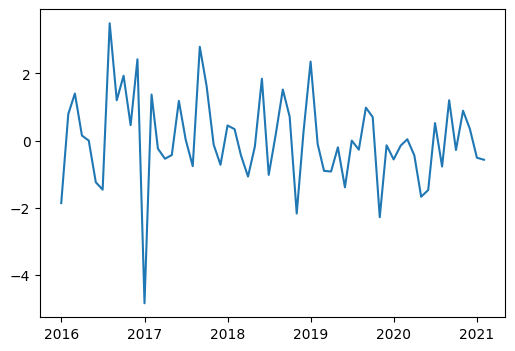

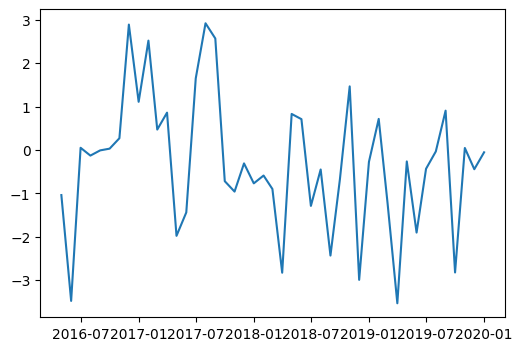

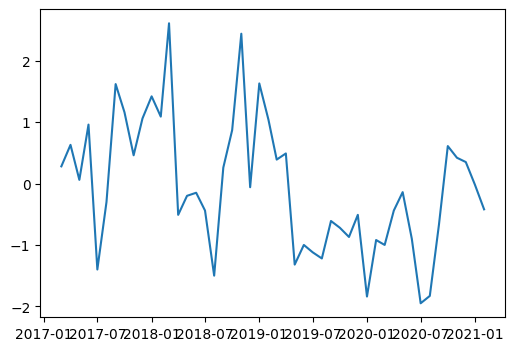

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(df['dates'][0], df['values'][0])
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(df['dates'][1], df['values'][1])
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(df['dates'][2], df['values'][2])
plt.show()

Теперь посмотрим на длину интервала

In [ ]:
# Извлекаем минимальные и максимальные даты для каждой строки
df['min_date'] = df['dates'].apply(min)
df['max_date'] = df['dates'].apply(max)
# Вычислим длину периода в днях
df['period_days'] = (df['max_date'] - df['min_date']).apply(lambda x: x.days)
df['period_days'].describe()

,period_days
count,80000.000000
mean,1930.775800
std,468.561586
min,1064.000000
25%,1552.000000
50%,1858.000000
75%,2282.000000
max,2922.000000


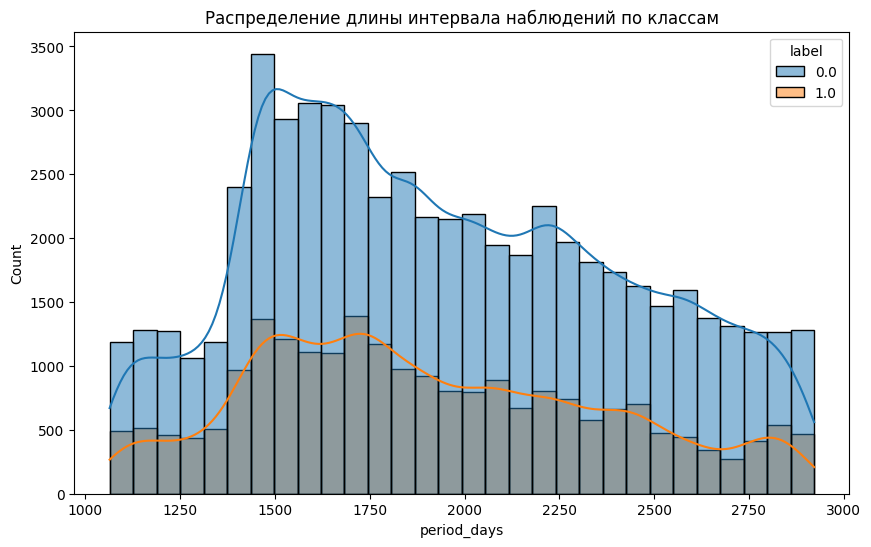

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='period_days', hue='label', kde=True, bins=30)
plt.title("Распределение длины интервала наблюдений по классам")
plt.show()

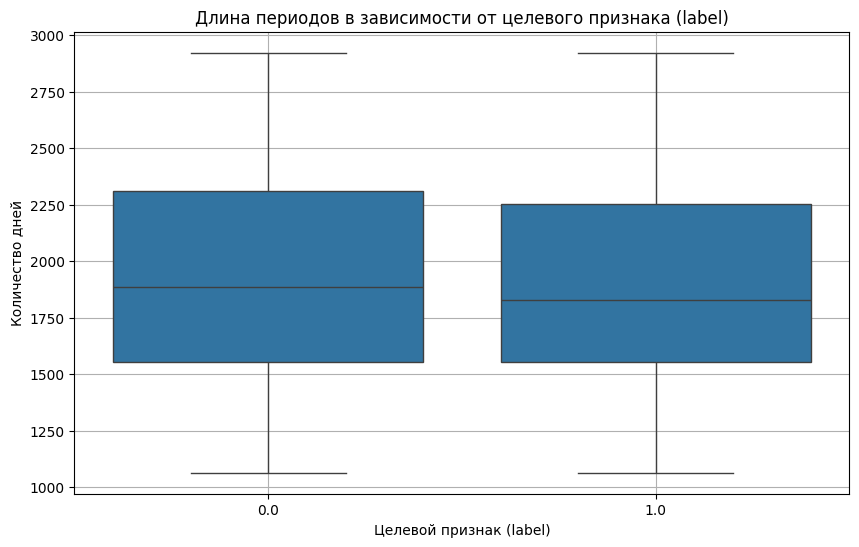

In [ ]:
# Boxplot по длине периодов
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='period_days')
plt.title('Длина периодов в зависимости от целевого признака (label)')
plt.xlabel('Целевой признак (label)')
plt.ylabel('Количество дней')
plt.grid(True)
plt.show()

Интервалы по классам довольно совпадают, но их все равно можно использовать в обучении

Теперь посмотрим на интервалы между датами

In [ ]:
np.diff(df['dates'][0])

array([datetime.timedelta(days=31), datetime.timedelta(days=29),
       datetime.timedelta(days=31), datetime.timedelta(days=30),
       datetime.timedelta(days=31), datetime.timedelta(days=30),
       datetime.timedelta(days=31), datetime.timedelta(days=31),
       datetime.timedelta(days=30), datetime.timedelta(days=31),
       datetime.timedelta(days=30), datetime.timedelta(days=31),
       datetime.timedelta(days=31), datetime.timedelta(days=28),
       datetime.timedelta(days=31), datetime.timedelta(days=30),
       datetime.timedelta(days=31), datetime.timedelta(days=30),
       datetime.timedelta(days=31), datetime.timedelta(days=31),
       datetime.timedelta(days=30), datetime.timedelta(days=31),
       datetime.timedelta(days=30), datetime.timedelta(days=31),
       datetime.timedelta(days=31), datetime.timedelta(days=28),
       datetime.timedelta(days=31), datetime.timedelta(days=30),
       datetime.timedelta(days=31), datetime.timedelta(days=30),
       datetime.timedelta

In [ ]:
df['diff_interval'] = df['dates'].apply(lambda x: [i.days for i in np.diff(x)])
df['diff_interval']

,diff_interval
0,"[31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 3..."
1,"[31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 3..."
2,"[31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 2..."
3,"[31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 3..."
4,"[31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 3..."
...,...
79995,"[31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 3..."
79996,"[31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 3..."
79997,"[31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 2..."
79998,"[29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 3..."


Видим, что похоже мы имеем дело с временными рядами, у которых разница между датами месяц. А это значит, что дальнейшее исследование необходимо проводить по месяцам

Теперь посмотрим как вообще расположены временные ряды и их пересечение

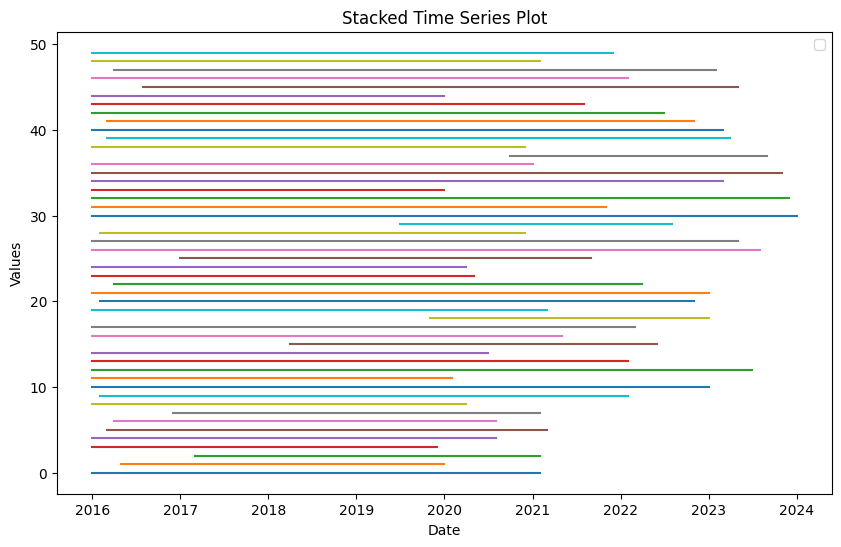

In [ ]:
plt.figure(figsize=(10, 6))
for index, row in df[:50].iterrows():
    plt.plot(row['dates'], [index]*len(row['dates']))

plt.title('Stacked Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(loc='upper right')
plt.show()

Как можно заметить, очень многие данные начинаются с одной даты в 2016 году. Пока сложно предположить что это за данные, но есть вероятность что это один и тот же показатель, который собирался разными компаниями или датчиками начиная с одного и того же времени

Теперь давайте посмотрим на распределение основной статистики значений по классам

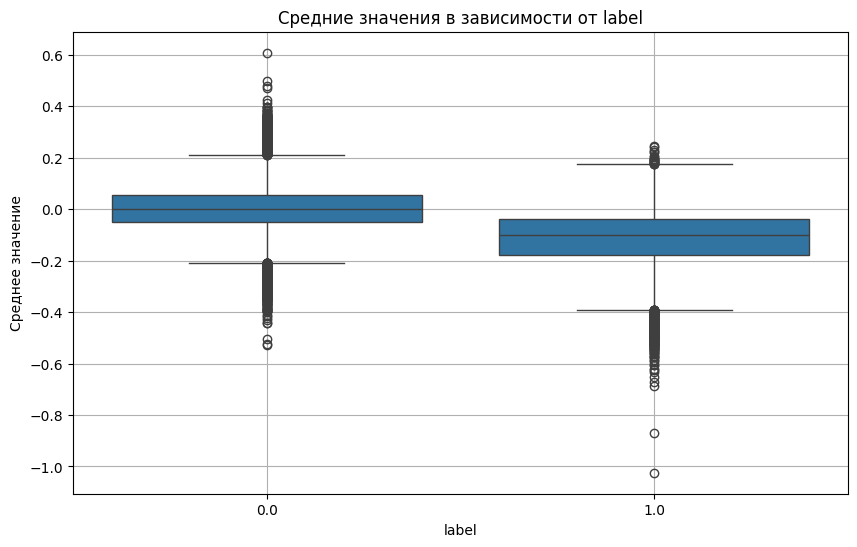

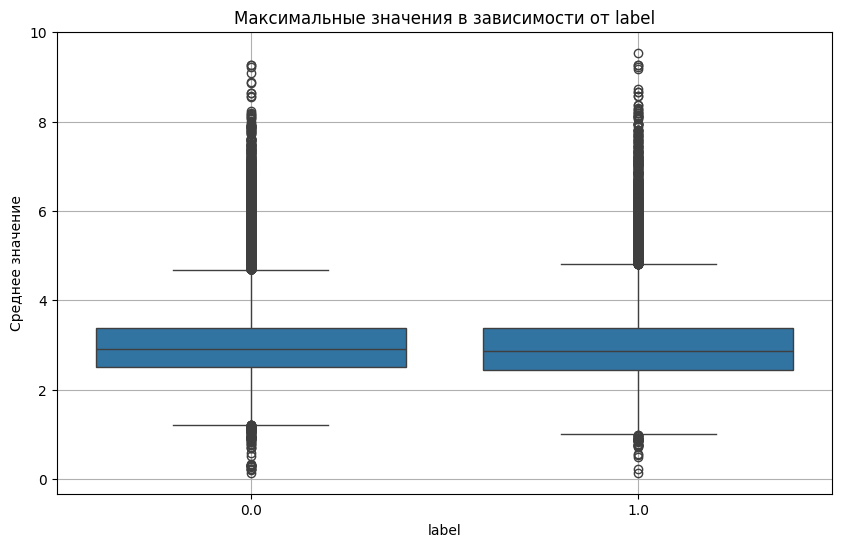

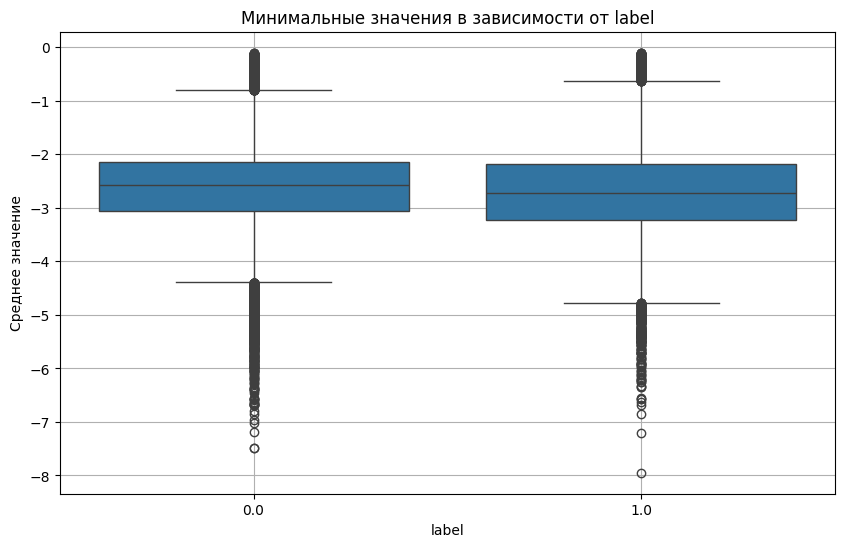

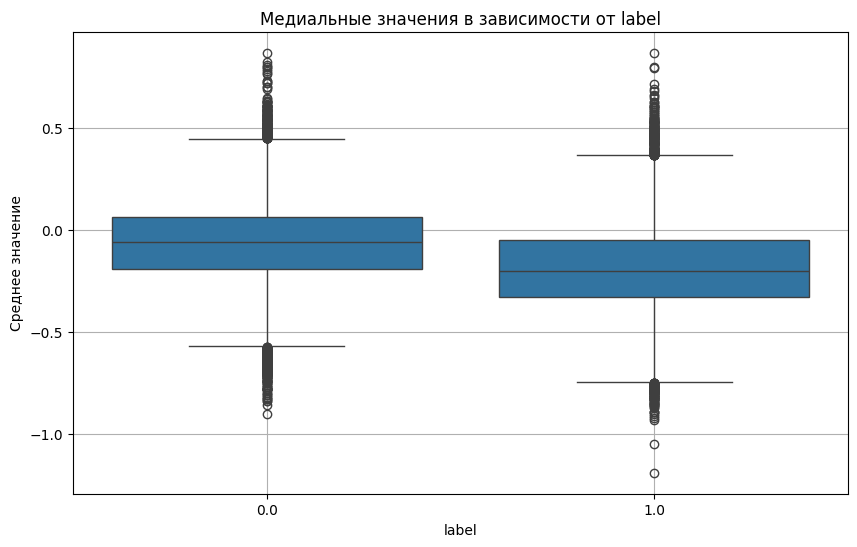

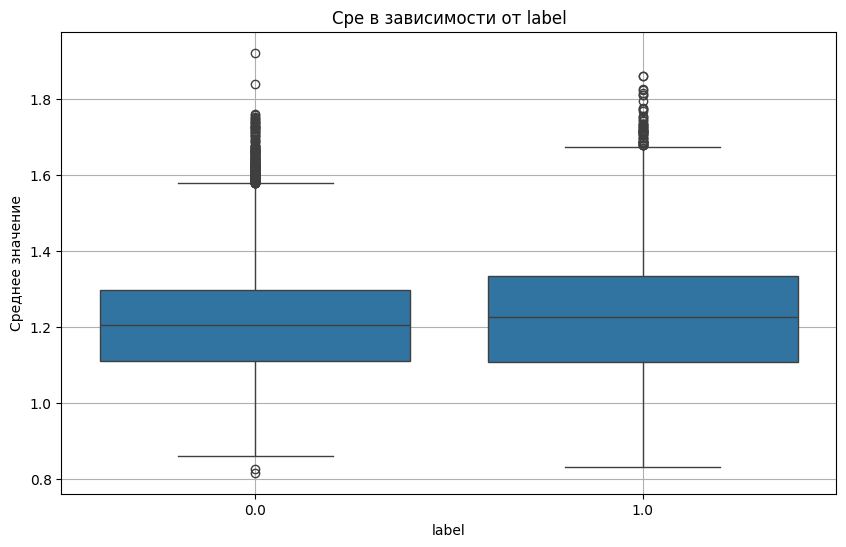

In [ ]:
# Рассчитаем основную статистику по значениям
df['values_mean'] = df['values'].apply(np.mean)
df['values_min'] = df['values'].apply(np.min)
df['values_max'] = df['values'].apply(np.max)
df['values_std'] = df['values'].apply(np.std)
df['values_median'] = df['values'].apply(np.median)

# Среднее значение по целевому признаку
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='values_mean')
plt.title('Средние значения в зависимости от label')
plt.xlabel('label')
plt.ylabel('Среднее значение')
plt.grid(True)
plt.show()

# Максимальное значение по целевому признаку
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='values_max')
plt.title('Максимальные значения в зависимости от label')
plt.xlabel('label')
plt.ylabel('Среднее значение')
plt.grid(True)
plt.show()

# Минимальное значение по целевому признаку
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='values_min')
plt.title('Минимальные значения в зависимости от label')
plt.xlabel('label')
plt.ylabel('Среднее значение')
plt.grid(True)
plt.show()

# Медиальное значение по целевому признаку
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='values_median')
plt.title('Медиальные значения в зависимости от label')
plt.xlabel('label')
plt.ylabel('Среднее значение')
plt.grid(True)
plt.show()

# std по целевому признаку
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='values_std')
plt.title('Сре в зависимости от label')
plt.xlabel('label')
plt.ylabel('Среднее значение')
plt.grid(True)
plt.show()

Визуально данные отличаются не сильно, но так как у нас значения находятся в диапазоне от -8 до 10, разница в десятые доли тоже может иметь значение, так что давайте построим плотности

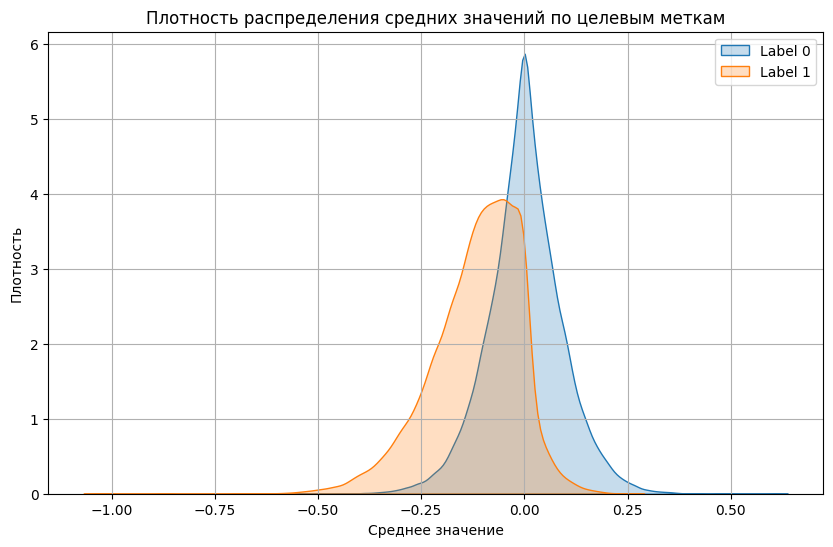

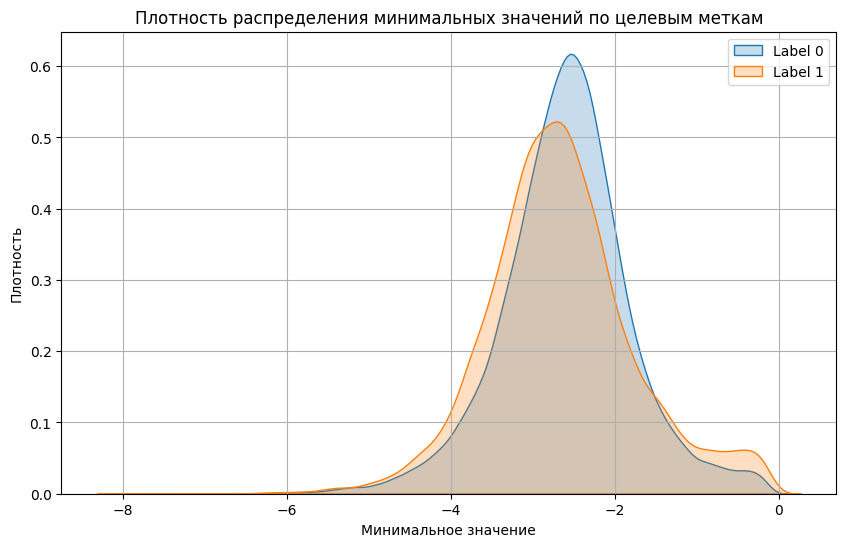

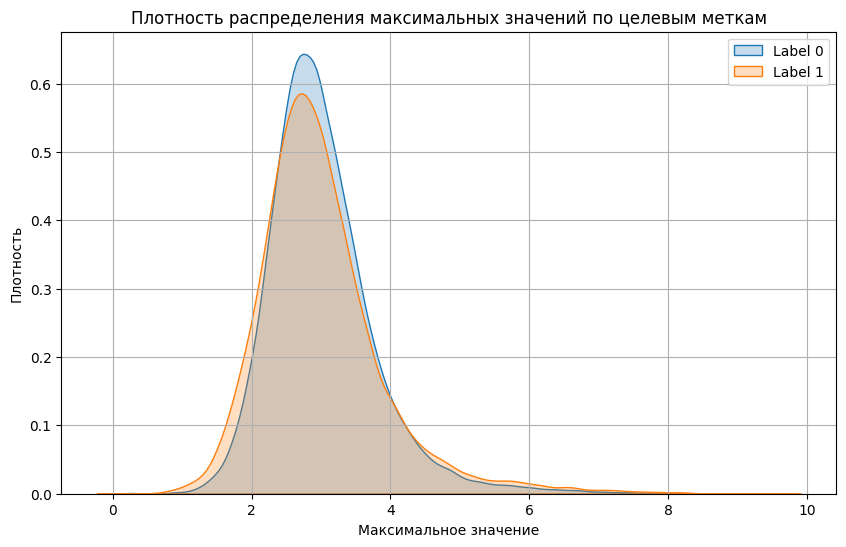

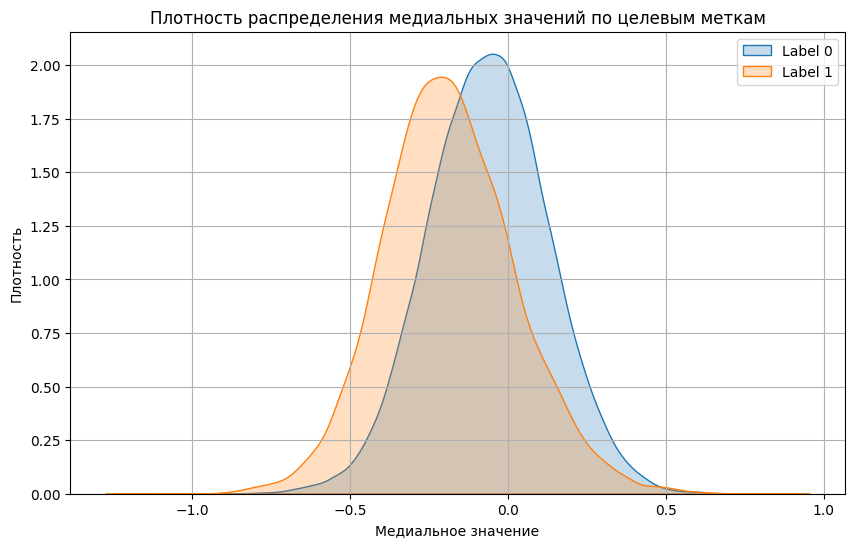

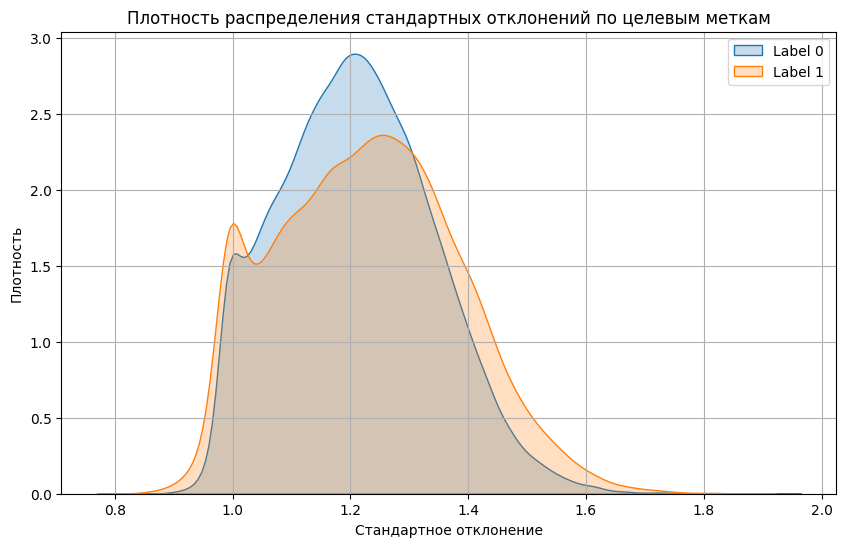

In [ ]:
# Плотность распределения средних значений по целевым меткам
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['label'] == 0.0]['values_mean'], label='Label 0', fill=True)
sns.kdeplot(df[df['label'] == 1.0]['values_mean'], label='Label 1', fill=True)
plt.title('Плотность распределения средних значений по целевым меткам')
plt.xlabel('Среднее значение')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

# Плотность распределения минимальных значений по целевым меткам
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['label'] == 0.0]['values_min'], label='Label 0', fill=True)
sns.kdeplot(df[df['label'] == 1.0]['values_min'], label='Label 1', fill=True)
plt.title('Плотность распределения минимальных значений по целевым меткам')
plt.xlabel('Минимальное значение')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

# Плотность распределения максимальных значений по целевым меткам
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['label'] == 0.0]['values_max'], label='Label 0', fill=True)
sns.kdeplot(df[df['label'] == 1.0]['values_max'], label='Label 1', fill=True)
plt.title('Плотность распределения максимальных значений по целевым меткам')
plt.xlabel('Максимальное значение')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

# Плотность распределения медиальных значений по целевым меткам
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['label'] == 0.0]['values_median'], label='Label 0', fill=True)
sns.kdeplot(df[df['label'] == 1.0]['values_median'], label='Label 1', fill=True)
plt.title('Плотность распределения медиальных значений по целевым меткам')
plt.xlabel('Медиальное значение')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

# Плотность распределения стандартных отклонений по целевым меткам
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['label'] == 0.0]['values_std'], label='Label 0', fill=True)
sns.kdeplot(df[df['label'] == 1.0]['values_std'], label='Label 1', fill=True)
plt.title('Плотность распределения стандартных отклонений по целевым меткам')
plt.xlabel('Стандартное отклонение')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

Перекрытие областей есть, особенно в случаях с максимальными, минимальными значениями и стандартными отклонениями. А вот среднее и медиана не так хорошо покрывается между классами, что означает, что оно может оказать влияние на алгоритм классификации

Теперь посмотрим на разницу между значениями по классам

In [ ]:
# Вычисление разностей между соседними значениями
df['diff_values'] = df['values'].apply(lambda x: np.diff(x))
# Добавим средние разницы для каждого ряда
df['mean_diff'] = df['diff_values'].apply(np.mean)
df['month'] = df['dates'].apply(lambda x: [d.month for d in x])

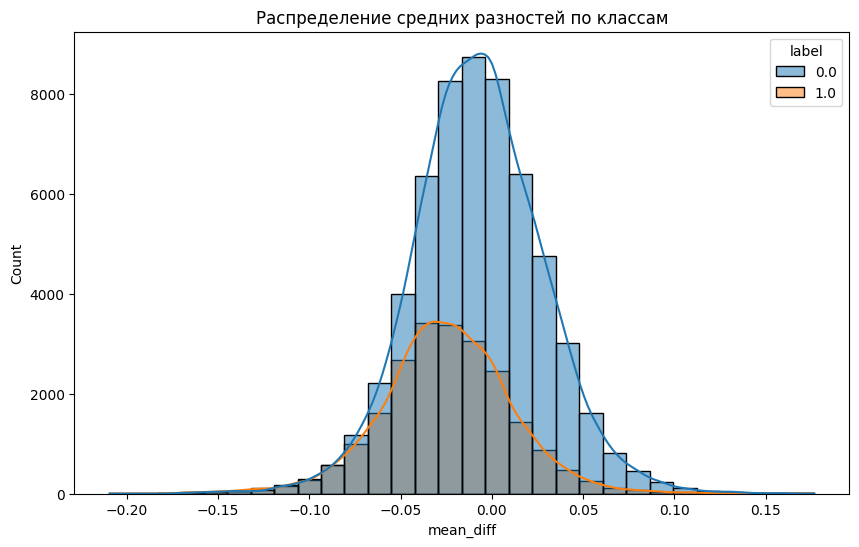

In [ ]:
# Построим график распределения средних разностей по классам
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='mean_diff', hue='label', kde=True, bins=30)
plt.title("Распределение средних разностей по классам")
plt.show()

Далее посмотрим на выбросы в данных

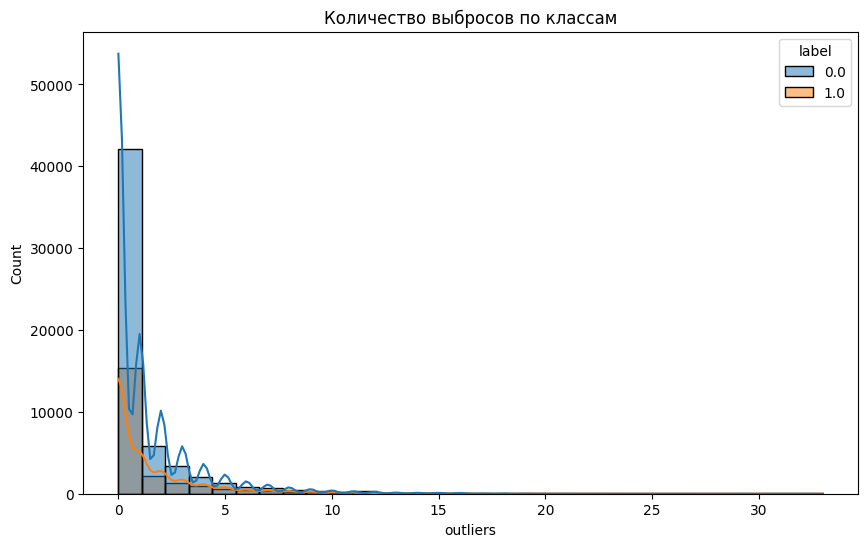

In [ ]:
# Вычислим межквартильный размах для каждого ряда
df['Q1'] = df['values'].apply(lambda x: np.percentile(x, 25))
df['Q3'] = df['values'].apply(lambda x: np.percentile(x, 75))
df['IQR'] = df['Q3'] - df['Q1']

# Добавим признак наличия выбросов
df['outliers'] = df.apply(lambda row: len([v for v in row['values'] if v < (row['Q1'] - 1.5 * row['IQR']) or v > (row['Q3'] + 1.5 * row['IQR'])]), axis=1)

# Построим график выбросов по классам
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='outliers', hue='label', kde=True, bins=30)
plt.title("Количество выбросов по классам")
plt.show()

Посмотрим на наблюдения по месяцам

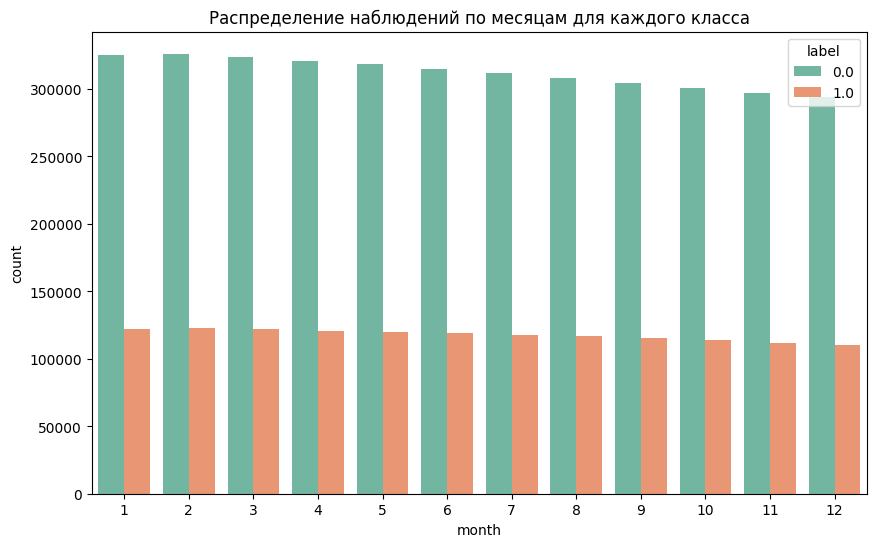

In [ ]:
# Преобразуем к длинному формату для построения графика
df_exploded['month'] = df_exploded['dates'].apply(lambda x: x.month)

# Посмотрим на распределение наблюдений по месяцам для каждого класса
plt.figure(figsize=(10, 6))
sns.countplot(x='month', hue='label', data=df_exploded, palette='Set2')
plt.title('Распределение наблюдений по месяцам для каждого класса')
plt.show()

Количетсво значений оказалось примерно одинаковым по месяцам, причем распределение одинаково и между классами, но что по средним значеним?

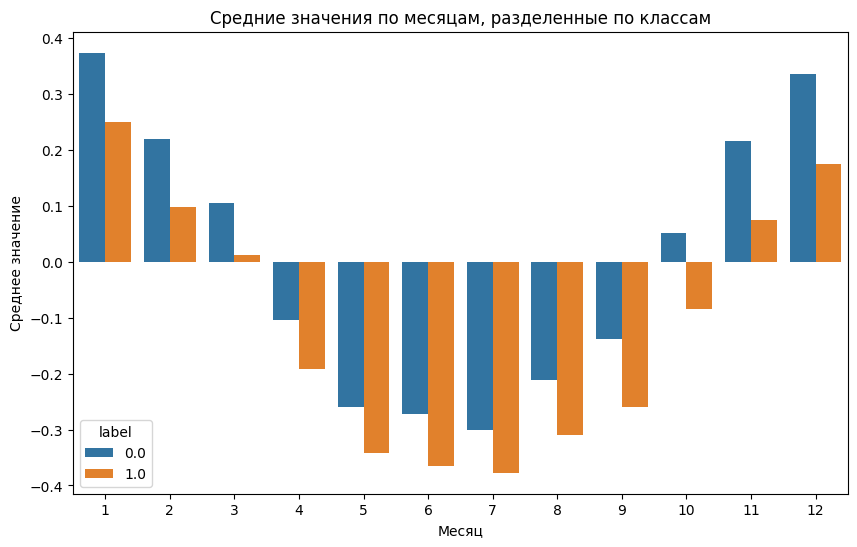

In [ ]:
# Рассчитываем средние значения для каждого месяца и метки класса
df_avg = df_exploded.groupby(['month', 'label'])['values'].mean().reset_index()

# Строим гистограмму
plt.figure(figsize=(10,6))
sns.barplot(data=df_avg, x='month', y='values', hue='label')
plt.title('Средние значения по месяцам, разделенные по классам')
plt.xlabel('Месяц')
plt.ylabel('Среднее значение')
plt.show()

Наблюдаем некоторую сезонность. К лету значение становится отрицательным, а зимой возрастает до пика. Вероятнее всего это значение связано с каким-то "зимним" коэффициентом.

Теперь посмотрим по годам

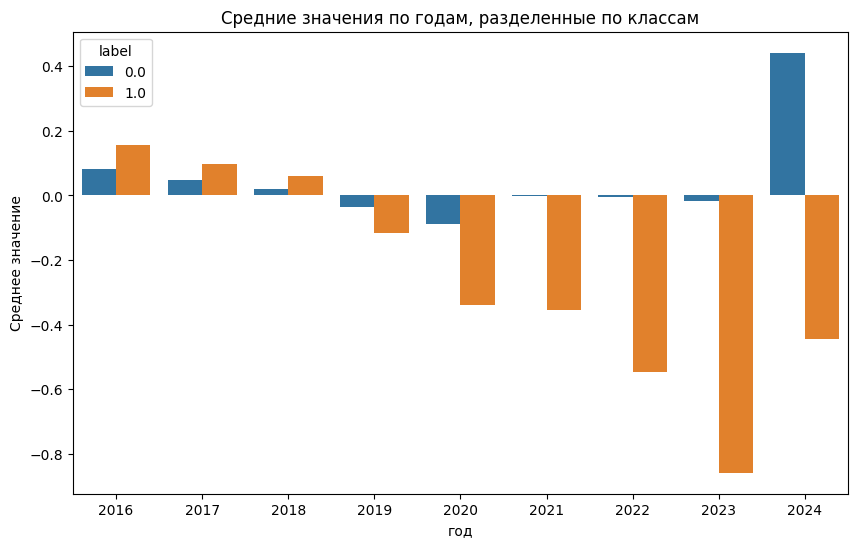

In [ ]:
df_exploded['year'] = df_exploded['dates'].apply(lambda x: x.year)

# Рассчитываем средние значения для каждого года и метки класса
df_avg = df_exploded.groupby(['year', 'label'])['values'].mean().reset_index()

# Строим гистограмму
plt.figure(figsize=(10,6))
sns.barplot(data=df_avg, x='year', y='values', hue='label')
plt.title('Средние значения по годам, разделенные по классам')
plt.xlabel('год')
plt.ylabel('Среднее значение')
plt.show()

Похоже, что значение с 2016 года пошло на спад. Может это коэффициент связанный с погодой и перед нами датасет показывающий глобальное потепление ;)
В любом случае пока не понятно по какому принципу формируется метка класса

# 3. Генерация признаков

Мы уже сгенерировали довольно много признаков при первичном анализе датасета, можно использовать их и добавить еще некоторые

p.s. Я очень хотел использовать библиотеку tsfresh для генерации, но у меня просто не хватило оперативы в ноутбуке. Несколько раз запускал ее на ночь, но она так и не доработала до конца, поэтому пришлось брать что есть

Количество уникальных месяцев и лет

In [ ]:
df['unique_months'] = df['month'].apply(lambda x: len(set(x)))
df['unique_years'] = df['dates'].apply(lambda x: len(set([d.year for d in x])))

Скошенность (Skewness) и эксцесс (Kurtosis)

In [ ]:
from scipy.stats import skew, kurtosis

df['values_skew'] = df['values'].apply(lambda x: skew(x))
df['values_kurtosis'] = df['values'].apply(lambda x: kurtosis(x))

Максимальная и минимальная разности

In [ ]:
df['max_diff'] = df['diff_values'].apply(np.max)
df['min_diff'] = df['diff_values'].apply(np.min)

Процентили

In [ ]:
df['values_pct_10'] = df['values'].apply(lambda x: np.percentile(x, 10))
df['values_pct_90'] = df['values'].apply(lambda x: np.percentile(x, 90))

Частотный спектр

In [ ]:
df['fft_values'] = df['values'].apply(lambda x: np.abs(np.fft.fft(x)))
df['fft_max'] = df['fft_values'].apply(np.max)
df['fft_mean'] = df['fft_values'].apply(np.mean)
df['fft_std'] = df['fft_values'].apply(np.std)

Лаг-автокорреляция

In [ ]:
from statsmodels.tsa.stattools import acf

df['autocorr_lag1'] = df['values'].apply(lambda x: acf(x, nlags=1)[1])
df['autocorr_lag2'] = df['values'].apply(lambda x: acf(x, nlags=2)[2] if len(x) > 2 else np.nan)

Число пиков в ряду

In [ ]:
from scipy.signal import find_peaks

df['n_peaks'] = df['values'].apply(lambda x: len(find_peaks(x)[0]))

# 4. Формирование тренировочной и тестовой выборки, экспорт датасета

Посмотрим что получилось

In [ ]:
df.head()

,id,dates,values,label,dates_len,values_len,min_date,max_date,period_days,diff_interval,...,min_diff,values_pct_10,values_pct_90,fft_values,fft_max,fft_mean,fft_std,autocorr_lag1,autocorr_lag2,n_peaks
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0,62,62,2016-01-01,2021-02-01,1858,"[31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 3...",...,-7.26,-1.453000,1.610000,"[1.4700000000000015, 11.30893234913658, 4.4849...",20.405218,9.116305,5.272787,-0.111439,-0.096472,19
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0,45,45,2016-05-01,2020-01-01,1340,"[31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 3...",...,-4.46,-2.668409,1.576236,"[13.984957017678555, 19.89079246268722, 9.1761...",19.890792,9.894816,3.929012,0.189286,0.023428,14
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0,48,48,2017-03-01,2021-02-01,1433,"[31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 2...",...,-3.12,-1.344000,1.238000,"[2.210000000000001, 20.514391558737533, 5.3759...",20.514392,6.128681,4.121429,0.500204,0.356705,15
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0,48,48,2016-01-01,2019-12-01,1430,"[31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 3...",...,-2.39,-1.623000,1.258000,"[6.24, 30.75772108580178, 4.1312753467152845, ...",30.757721,5.483513,5.927131,0.688139,0.500714,11
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0,56,56,2016-01-01,2020-08-01,1674,"[31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 3...",...,-4.12,-1.675000,1.500000,"[15.15, 5.319691984766741, 2.669083302096537, ...",21.570369,8.235742,5.164189,0.087387,-0.145388,17


In [ ]:
df.columns

Index(['id', 'dates', 'values', 'label', 'dates_len', 'values_len', 'min_date',
       'max_date', 'period_days', 'diff_interval', 'mean_interval',
       'values_mean', 'values_min', 'values_max', 'values_std',
       'values_median', 'diff_values', 'mean_diff', 'month', 'Q1', 'Q3', 'IQR',
       'outliers', 'unique_months', 'unique_years', 'values_skew',
       'values_kurtosis', 'max_diff', 'min_diff', 'values_pct_10',
       'values_pct_90', 'fft_values', 'fft_max', 'fft_mean', 'fft_std',
       'autocorr_lag1', 'autocorr_lag2', 'n_peaks'],
      dtype='object')

Создадим датасет признаков и меток класса

In [130]:
x = df[['dates_len', 'period_days',
       'values_mean', 'values_min', 'values_max', 'values_std',
       'values_median', 'mean_diff', 'Q1', 'Q3', 'IQR',
       'outliers', 'unique_months', 'unique_years', 'values_skew',
       'values_kurtosis', 'max_diff', 'min_diff', 'values_pct_10',
       'values_pct_90', 'fft_max', 'fft_mean', 'fft_std',
       'autocorr_lag1', 'autocorr_lag2', 'n_peaks']]
y = df['label']


Проверим, что в признаки не залетело массивов

In [131]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dates_len        80000 non-null  int64  
 1   period_days      80000 non-null  int64  
 2   values_mean      79912 non-null  float64
 3   values_min       79912 non-null  float64
 4   values_max       79912 non-null  float64
 5   values_std       79912 non-null  float64
 6   values_median    79912 non-null  float64
 7   mean_diff        79912 non-null  float64
 8   Q1               79912 non-null  float64
 9   Q3               79912 non-null  float64
 10  IQR              79912 non-null  float64
 11  outliers         80000 non-null  int64  
 12  unique_months    80000 non-null  int64  
 13  unique_years     80000 non-null  int64  
 14  values_skew      79912 non-null  float64
 15  values_kurtosis  79912 non-null  float64
 16  max_diff         79912 non-null  float64
 17  min_diff    

Разбивка на тестовую и тренировочную выборки

In [132]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2,
                                                    stratify=y)

In [133]:
df.to_csv('df.csv', index=False)
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)